In this notebook we evaluate the fine tuned Gemma 2b model. Evaluation of machine translation task is a tough task. Translation is an open ended task, a sentence can have multiple correct translations. To ensure that the translations capture the right context, cultural nuances, idiomatic expressions, evaluations need to be evaluated manually by humans. Various scores available miss these aspects of translations. Human evaluations are expensive, and for our task we still rely on commonly used metrics used for translation task. 

We make use of BiLingual Evaluation Understudy score (BLEU score) proposed by Papineni, K., et al. fo evaluting our fine tuned model. This metric helps evaluating the quality of machine-translated text by comparing it to one or more reference translations. The score ranges from 0 to 1, with 1 indicating a perfect match between the machine translation and the reference translation(s).

To see how much our finetuning has improved the model, we take a random sample of 1000 examples from the CFILT dataset that was not used in fine tuning the Gemma model. We compare the BLEU score for baseline model with that of fine tuned model on this sample. Further, we also compare how our fine tuned model performs against Nemotron-4-Mini-Hindi-4B-Instruct model released by Nvidia on this test set. 



In [1]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

import os
import keras_nlp
import keras
import tensorflow as tf

import numpy as np
import pandas as pd
from transformers import AutoTokenizer, TrainingArguments, pipeline, AutoModelForCausalLM
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from tqdm import tqdm 

import warnings
import time

warnings.filterwarnings('ignore')
nltk.download("punkt")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.4.35 requires ml-dtypes>=0.4.0, but you have ml-dtypes 0.3.2 which is incompatible.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Configs 
# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

model_id = "gemma2_instruct_2b_en"
token_limit = 256

# Run at half precision.
#keras.config.set_floatx("bfloat16")


Following is a util function we use to calculate BLEU score, it uses the sentence_bleu function available in NLTK package. For calculating BLEU score, we build n-grams of translated and reference text, and calculate the precision of translated text for each n-gram (1-gram, 2-gram, 3-gram and so on). To prevent the machine translation from getting undue credit for repeating words excessively, we limit the count of n-grams in the machine-generated translation to the maximum count found in any reference translation. This is known as clipping. The final score is calculated by taking geometric mean of the precisions at each n-gram. 

In [99]:
#!pip install sacrebleu


In [3]:
def calculate_bleu_score(reference, candidate):
    reference_tokens = word_tokenize(reference)
    candidate_tokens = word_tokenize(candidate)

    return sentence_bleu([reference_tokens], candidate_tokens)

def clean_model_output(txt):
    """Removes the control tokens from model output """
    txt = txt[txt.find('model') + 6 : -14]
    return txt

# util function to clean nemo translations
def clean_nemo_translations(txt):
    '''
    Finds index of control tokens and slices hindi text string between them.
    '''
    index_start = txt.find('<extra_id_1>Assistant\n')
    index_end = txt[index_start:].find('\n<extra_id_1>User\n')
    text = txt[index_start:index_start+index_end].replace('<extra_id_1>Assistant\n', '')
    text = text.replace('\n<extra_id_1>User\n', '')
    
    return text

In [4]:
# Helpers : https://github.com/google-gemini/gemma-cookbook/blob/main/Gemma/Advanced_Prompting_Techniques.ipynb
def convert_message_to_prompt(message: str, model_prefix: str = "") -> str:
    """Converts a message to a prompt for a large language model.

    Args:
        message: The message to convert (str).
        model_prefix: An optional prefix to prepend to the model response (str).

    Returns:
        A string containing the prompt for the large language model (str).
    """

    return (
        f"<start_of_turn>user\n Translate the sentence into hindi and only return the translation. Text :  {message}<end_of_turn>\n"
        f"<start_of_turn>model\n{model_prefix}"
    )

## Evalution - Test Sample 
We use a sample dataset containing 100 sentences. This was ot used while fine-tuning the model. We use base Gemma 2-2b model, our fine tuned version of Gemma 2-2b, and Nemotron 4b-Hindi-Instruct for translating the english sentences to hindi. Finally, we compute the BLEU scores for all three translations and compare them. 

Nemotron 4b Hindi Instruct is a state-of-the-art model released by Nvidia. The authors Joshi et al. (2024) include empirical studies on various language translation benchmark datasets, that show that Nemotron 4b performs really well in Hindi language generation task. 

References: 
1. Joshi, R., Singla, K., Kamath, A., Kalani, R., Paul, R., Vaidya, U., ... & Long, E. (2024). Adapting Multilingual LLMs to Low-Resource Languages using Continued Pre-training and Synthetic Corpus. arXiv preprint arXiv:2410.14815.

In [5]:
test_sample = pd.read_csv('/kaggle/input/test-sample/test_sample_final.csv')
# test_sample.drop(['Unnamed: 0.1','Unnamed: 0'], axis = 1, inplace = True)

In [26]:
test_sample['nemo_translation_clean'] = test_sample['nemo_translation'].apply(lambda s : clean_nemo_translations(s))

In [63]:
test_sample[[ 'english', 'hindi','predictions_woft_clean', 'predictions_ft_clean', 'nemo_translation_clean']].sample(n = 5)

,english,hindi,predictions_woft_clean,predictions_ft_clean,nemo_translation_clean
19,"The Rural Distrct President of Congress, Jaide...",इस दौरान कांग्रेस के ग्रामीण जिला अध्यक्ष जयदी...,राष्ट्रीय कांग्रेस के ग्रामीण क्षेत्र के अध्यक...,"प्रधानमंत्री के उपमहौदय के अध्यक्ष, जयदवस, धरण...","कांग्रेस के ग्रामीण जिला अध्यक्ष जयदीप धनखड़, ..."
50,Flight Centre seem to be bucking the trend.,फ्लाइट सेन्टर इस चलन को आगे बढ़ा रहा है।,उड़ान केंद्र ट्रेंड का विरोध कर रहे हैं।,फ्लाट के लिए कुछ उभारते हैं।,उड़ान केंद्र की प्रवृत्ति को चुनौती दे रहा है।
64,"The EU won't disappear, but it will revert to ...","यूरो पूरी तरह समाप्त तो नहीं होगा, लेकिन यह फु...","ईयू खत्म नहीं होगा, लेकिन यह कुछ ऐसा बन जाएगा ...","भारतीय विदेशी ने दुनिया को अपराहे नही, लेकिन आ...","यूरोपीय संघ विलुप्त नहीं होगा, लेकिन यह सामान्..."
58,Most of the skirmishes have taken place in Sof...,"झड़पों के अधिकांशसोफा ला प्रांत मेंहै, जोमापुट...","सफोला प्रांत में ज्यादातर युद्ध हुए हैं, जो मा...","उनके पास कई छोटे स्तूपों पर सौदा किया गया है, ...","अधिकांश झड़पें सोफाला प्रांत में हुई हैं, जो म..."
53,Claiming to be a trading firm the accused open...,आरोपी ट्रेडिंग फर्म का हवाला देकर निवेशकों के ...,"उनके द्वारा खुद को व्यापारिक कंपनी बताते हुए, ...",धोखों के सदस्य किसी ऐमान की संपदा प्रणाम को उद...,"एक व्यापारिक फर्म होने का दावा करते हुए, आरोपी..."


In [53]:

test_sample["BLEU_Score_ft"] = test_sample[
    ["hindi", "predictions_ft_clean"]
].apply(
    lambda inputs: calculate_bleu_score(inputs[0], inputs[1]), axis=1
)


test_sample["BLEU_Score_base"] = test_sample[
    ["hindi", "predictions_woft_clean"]
].apply(
    lambda inputs: calculate_bleu_score(inputs[0], inputs[1]), axis=1
)

test_sample["BLEU_Score_nemo"] = test_sample[
    ["hindi", "nemo_translation_clean"]
].apply(
    lambda inputs: calculate_bleu_score(inputs[0], inputs[1]), axis=1
)
print(f"Average BLEU Score for LoRA fine tuned model: {test_sample['BLEU_Score_ft'].mean().round(4)}")
print(f"Average BLEU Score for base Gemma model: {test_sample['BLEU_Score_base'].mean().round(4)}")
print(f"Average BLEU Score for Nvidia Nemo 4b mini model: {test_sample['BLEU_Score_nemo'].mean().round(4)}")

Average BLEU Score for LoRA fine tuned model: 0.3653
Average BLEU Score for base Gemma model: 0.338
Average BLEU Score for Nvidia Nemo 4b mini model: 0.3349


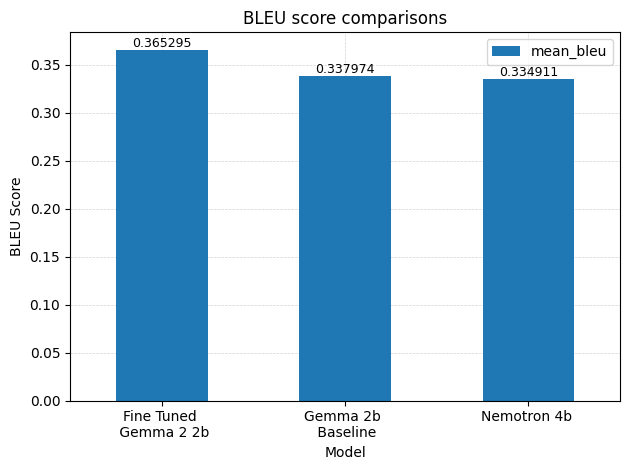

In [118]:
import matplotlib.pyplot as plt
# data wrangling
tmp_df = test_sample[['BLEU_Score_ft', 'BLEU_Score_base', 'BLEU_Score_nemo']].mean().reset_index()
tmp_df.columns = ['model', 'mean_bleu'] 
tmp_df['mean_bleu'] = tmp_df['mean_bleu'].apply(lambda x: np.round(x, 4))

#base plot
axes = tmp_df.plot(x = 'model', y = 'mean_bleu', kind = 'bar')

# grid lines
_=axes.grid(color='lightgray', linestyle='--', linewidth=0.5)
_=axes.set_axisbelow(True)
# annotation
_=axes.bar_label(ax.containers[-1], fontsize=9, rotation=0)

# tick marks 
_=plt.xticks(rotation = 0)
_=axes.set_xticklabels(['Fine Tuned \n Gemma 2 2b', 'Gemma 2b \n Baseline', 'Nemotron 4b '])

#title and labels
_=axes.set_xlabel('Model')
_=axes.set_ylabel('BLEU Score')
plt.title('BLEU score comparisons')
_ = plt.tight_layout()
plt.show()



From the plot above we see that average BLUE score is slightly higher for our fine tuned model on this test set. Let's compare some translations with high BLEU score for fine tuned model.

In [123]:
# High score translations 
test_sample.sort_values(by = 'BLEU_Score_ft', ascending = False).head(1)[['english','hindi',  'nemo_translation_clean', 'predictions_ft_clean', 'BLEU_Score_ft', 'BLEU_Score_nemo']].to_dict()

{'english': {75: 'President Armando Guebuza has sought to play down concerns about instability.'},
 'hindi': {75: 'राष्ट्रपति अर्मांडो जीबुझां ने अस्थिरता के बारे में चिंताओं को  बेक़दर करने कीमांग की है.'},
 'nemo_translation_clean': {75: 'राष्ट्रपति आर्मंडो गुएबुजा ने अस्थिरता के बारे में चिंताओं को कम करने की कोशिश की है।'},
 'predictions_ft_clean': {75: 'प्रधानमंत्री ने राष्ट्रपति भूतान राजू को रणजीभाल्य को राष्ट्रपति से कहा कि राष्ट्रपति ने गृह में रणक्षमूल्य की आशा रखी है।'},
 'BLEU_Score_ft': {75: 0.6985342056580097},
 'BLEU_Score_nemo': {75: 0.4071220775553065}}

In above example we see that even though the BLEU score for the translation by our fine-tuned model is comparable to that of Nemotron model. The meaning is lost in the translation of our model. Nemotron does a really good job in translating the english sentence to hindi. Our model needs more improvement. This will be experimented upon in future notebooks.

## Conclusion and Future work

In this exercise we fine-tune Gemma 2 2b model for language translation task. We setup a training pipeline using keras-nlp and make use of Kaggle's free notebook instance with Nvidia P100 GPU for this task. For fine-tuning, we apply supervised fine-tuning with an open source Hindi-English corpus, CFILT, and a Parameter-Efficient Fine-Tuning (PEFT) technique called Low-Rank Adaptation (LoRA). We compare the performance of fine tuned model with that of Nemotron-4b-hindi instruct model using BLEU score. 

In future we aim to use advanced techniques to techniques like few shot prompting for alignment, quantization to reducing memory usage of model so that we can use bigger dataset for fine tuning. Using these techniques we aim to improve our model's performance further.

# Appendix

## Inference Code

### Load dataset

In [5]:
# splits = {
#     "train": "data/train-00000-of-00001.parquet",
#     "validation": "data/validation-00000-of-00001.parquet",
#     "test": "data/test-00000-of-00001.parquet",
# }

# # load the parquet files from huggingface
# train = pd.read_parquet(
#     "hf://datasets/cfilt/iitb-english-hindi/" + splits["train"]
# )
# val = pd.read_parquet(
#     "hf://datasets/cfilt/iitb-english-hindi/" + splits["validation"]
# )
# test = pd.read_parquet(
#     "hf://datasets/cfilt/iitb-english-hindi/" + splits["test"]
# )

# print(train.shape)
# print(val.shape)
# print(test.shape)

## Load Gemma 2 2b baseline model

In [6]:
# device_name = tf.test.gpu_device_name()
# with tf.device('/GPU:0'):
#     gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
#     gemma_lm.summary()

In [7]:
# tick_start = 0

# def tick():
#     global tick_start
#     tick_start = time.time()

# def tock():
#     print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

 
# def text_gen(prompt, debug = False):
#     input = convert_message_to_prompt(prompt)
#     if debug:
#         print(f'User input: {input}')
#     output = gemma_lm.generate(input, max_length=token_limit)
#     if debug:
#         print("\nGemma output:")
#         print(output)
#     return output


### Evaluating base model - BLEU score

In [124]:
# Get a test sample with 100 rows.
# test_sample = test.sample(100, random_state=42)
# print(test_sample.shape)
# test_sample["english"] = test_sample.translation.apply(lambda x: x.get("en"))
# test_sample["hindi"] = test_sample.translation.apply(lambda x: x.get("hi"))

# test_sample.head()

### Model inference 

In [10]:
# tick()
# test_sample["predictions_woft"] = test_sample.english.apply(
#     lambda text: text_gen(f"{text}")
# )
# tock()


In [11]:
# test_sample["predictions_woft_clean"] = test_sample.predictions_woft.apply(
#     lambda text: clean_model_output(text)
# )

In [14]:
# test_sample.to_csv('test_sample_nemo_gemma_base.csv')

## Fine Tuned Model 

### Loading save weights

In [13]:
# with tf.device('/GPU:0'):

#     gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_instruct_2b_en")
# #     # # Use the same LoRA rank that you trained
#     gemma_lm.backbone.enable_lora(rank=20)
    
#     # Load pre-trained LoRA weights
#     gemma_lm.backbone.load_lora_weights(f"/kaggle/input/gemma2b-fine-tuned/llm_mark1_20_epoch20.lora (1).h5")


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [125]:
# gemma_lm.compile()
# gemma_lm.summary()

In [126]:
# def text_gen(prompt, debug = False):
#     input = convert_message_to_prompt(prompt)
#     if debug:
#         print(f'User input: {input}')
#     output = gemma_lm.generate(input, max_length=token_limit)
#     if debug:
#         print("\nGemma output:")
#         print(output)
#     return output


In [127]:
# ## inference of the test set

# test_sample["predictions_ft"] = test_sample.english.apply(
#     lambda text: text_gen(f"{text}")
# )


# test_sample["predictions_ft_clean"] = test_sample.predictions_ft.apply(
#     lambda text: clean_model_output(text)
# )


# test_sample['pred_len'] = test_sample["predictions_ft_clean"].apply(lambda x: len(x))
# test_sample['gt_len'] = test_sample["hindi"].apply(lambda x: len(x))
# test_sample.head()


In [17]:
# test_sample.to_csv('test_sample_final.csv', index = False)

## Inference using Nemotron 



Nemotron-Mini-Hindi 4B is a bilingual SLM supporting both Hindi and English. It is based on Nemotron-Mini 4B. The model is trained using a mix of real and synthetic Hindi + English tokens, with continuous pre-training performed on 400B tokens. 
Architecture details : 
1. Transformer Decoder (auto-regressive language model)
2. Nemotron-Mini-4B uses a model embedding size of 3072
3. It has 32 attention heads.
4. It also uses Grouped-Query Attention (GQA) and Rotary Position Embeddings (RoPE).

In [ ]:
# %%capture
# !pip install accelerate


In [ ]:
# from transformers import AutoTokenizer, AutoModelForCausalLM

# # Load the tokenizer and model
# tokenizer  = AutoTokenizer.from_pretrained("nvidia/Nemotron-4-Mini-Hindi-4B-Instruct")#, device_map = 'cuda')
# model = AutoModelForCausalLM.from_pretrained("nvidia/Nemotron-4-Mini-Hindi-4B-Instruct")#, device_map = 'cuda')



In [ ]:
# ## Use the prompt template
# messages = [

#     {"role": "user", "content": "Translate this to english : 'भारत की संस्कृति के बारे में बताएं।''"},
#  ]
# tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt")#.to("cuda")


# outputs = model.generate(tokenized_chat, max_new_tokens=128) 
# print(tokenizer.decode(outputs[0]))

In [ ]:
# def generate_prompt_nemo(txt):
#     prompt = {"role": "user", "content": f"Translate this to Hindi : {txt}"} 
#     return [prompt]


In [ ]:
# test_sample['nemo_prompt'] = test_sample.english.apply(
#     lambda text: generate_prompt_nemo(text)
# )


In [ ]:
# # messages = generate_prompt_nemo(txt)
# def get_nemo_translations(prompt):
    
#     tokenized_chat = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt")#.to("cuda")

#     outputs = model.generate(tokenized_chat, max_new_tokens=128, top_k = 1 ) 
#     out = tokenizer.decode(outputs[0])
#     return out
# # tmp_translation_nemo = text_gen('Delta and JetBlue were among the airliners who have already submitted plans.')
# # clean_model_output(tmp_translation)


In [ ]:
# tqdm.pandas()
# test_sample['nemo_translation'] = test_sample.nemo_prompt.progress_apply(
#     lambda text: get_nemo_translations(text)
# )

In [ ]:
# test_sample.head()
# test_sample.to_csv('test_nemo_translations.csv')

In [ ]:
# test_sample["BLEU_Score_ft"] = test_sample[
#     ["hindi", "predictions_ft_clean"]
# ].apply(
#     lambda inputs: calculate_bleu_score(inputs[0], inputs[1]), axis=1
# )
# print(f"Average BLEU Score for LoRA fine tuned model: {test_sample['BLEU_Score_ft'].mean().round(4)}")

In [ ]:
# test_sample.to_csv('test_set.csv')